# SIFT Detector

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Example 1:

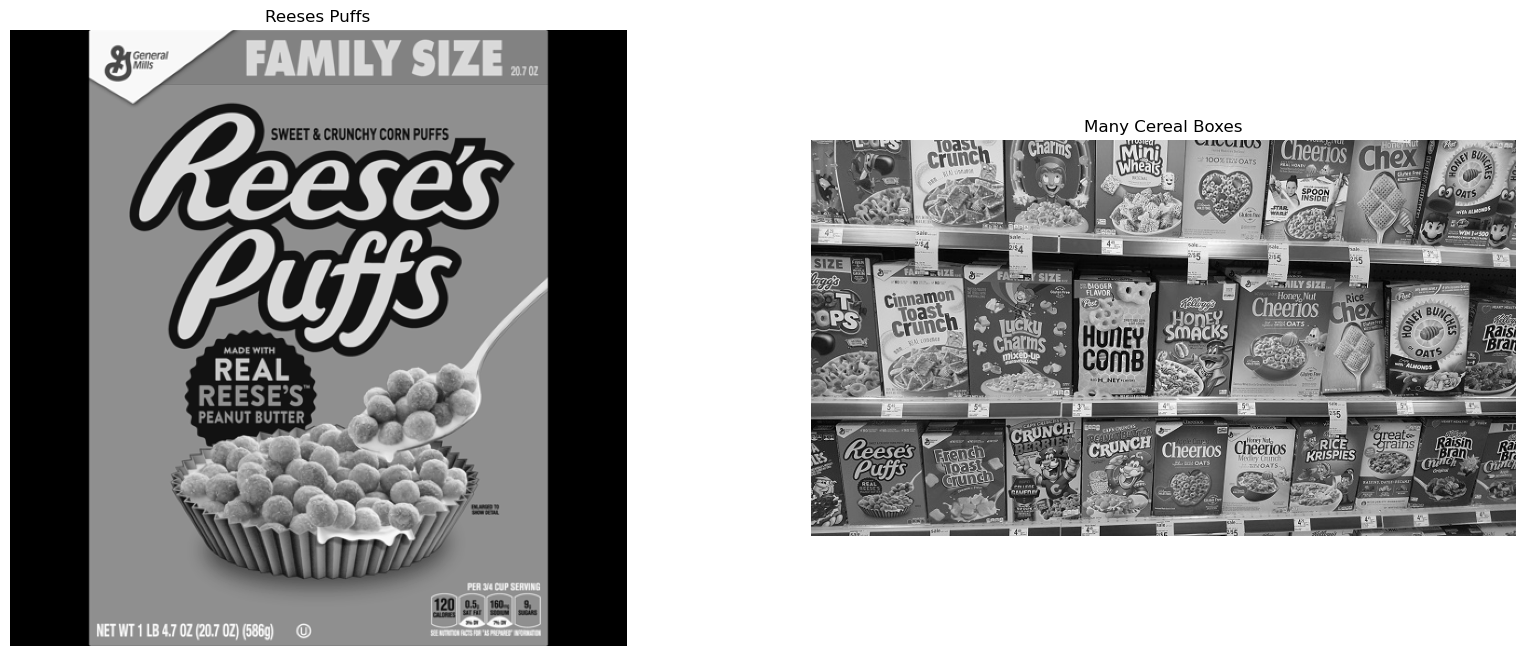

In [42]:
reeses_puffs = cv2.imread('data/images/reeses_puffs.png', cv2.IMREAD_GRAYSCALE)
many_cereals = cv2.imread('data/images/many_cereals.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.imshow(reeses_puffs, cmap = 'gray')
plt.title("Reeses Puffs")
plt.axis('off')

plt.subplot(122)
plt.imshow(many_cereals, cmap = 'gray')
plt.title("Many Cereal Boxes")
plt.axis('off');

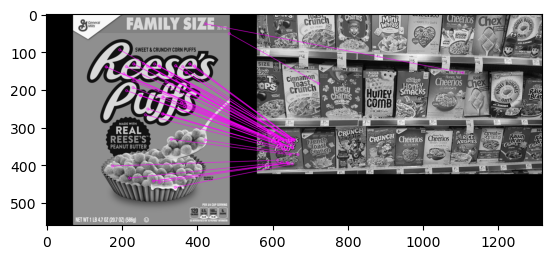

In [43]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(reeses_puffs, None)
kp2, des2 = sift.detectAndCompute(many_cereals, None)

# Normal SIFT
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)

results = cv2.drawMatches(reeses_puffs, kp1, many_cereals, kp2, matches[:50], None, matchColor=(255,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plt.imshow(results);

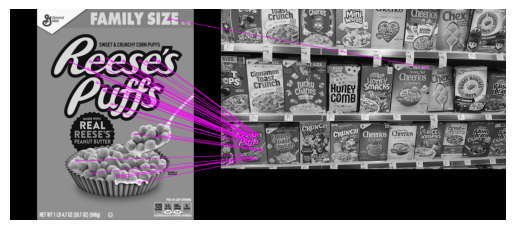

In [44]:
# SIFT with KNN and Ratio Test
matches = bf.knnMatch(des1, des2, k=2)
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

results = cv2.drawMatches(reeses_puffs, kp1, many_cereals, kp2, good, None, matchColor = (255, 0, 255), flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plt.imshow(results);
plt.axis('off');

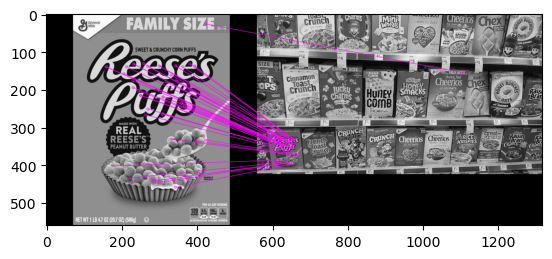

In [45]:
src = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

H, mask = cv2.findHomography(src, dst, cv2.RANSAC, ransacReprojThreshold=5)

output = cv2.drawMatches(reeses_puffs, kp1, many_cereals, kp2, good, None, matchColor = (255, 0, 255), flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plt.imshow(output);

# Image Transformations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Example 1:

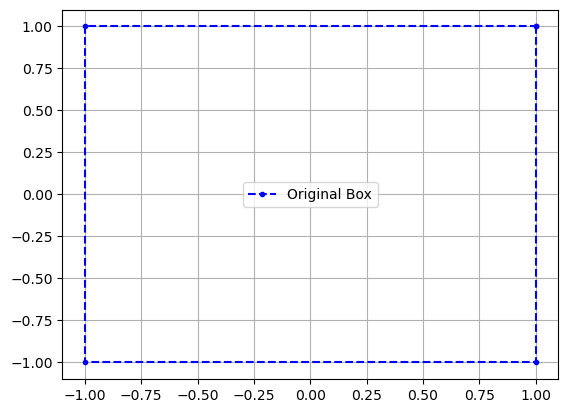

In [20]:
pts_arr = [
    [1,1],
    [1,-1],
    [-1,-1],
    [-1,1],
    [1,1]
]

pts = np.array(pts_arr)
plt.plot(pts[:,0], pts[:,1], label='Original Box', color='b', marker = '.', linestyle='--')
plt.legend()
plt.grid(True)

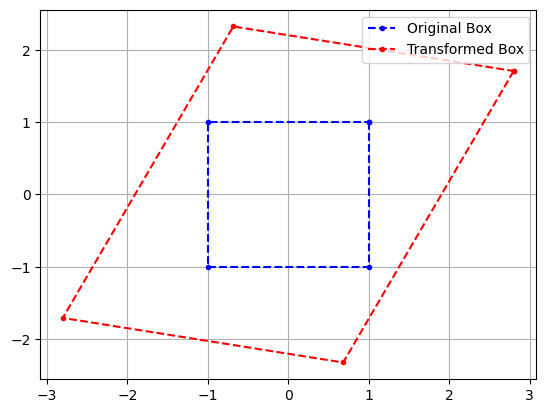

In [37]:
# Transformations

scale_factor = 2
rotation_deg = 20
shear_factor = 0.2

scale_matrix = np.array([[scale_factor, 0, 0],
                         [0, scale_factor, 0],
                         [0, 0, 1]])

rotation_rad = np.radians(rotation_deg)
rotation_matrix = np.array([[np.cos(rotation_rad), -np.sin(rotation_rad), 0],
                            [np.sin(rotation_rad), np.cos(rotation_rad), 0],
                            [0, 0, 1]])

shear_matrix = np.array([[1, shear_factor, 0],
                         [shear_factor, 1, 0],
                         [0, 0, 1]])

H = np.dot(scale_matrix,np.dot(rotation_matrix, shear_matrix))

# Add a new dimension into the points
input_pts = np.hstack((pts, np.ones((5,1))))

output_pts = np.dot(input_pts, H)

plt.plot(input_pts[:,0], input_pts[:,1], label='Original Box', color='b', marker = '.', linestyle='--')
plt.plot(output_pts[:,0], output_pts[:,1], label='Transformed Box', color='r', marker = '.', linestyle='--')
plt.legend()
plt.grid(True)

## Example 2:

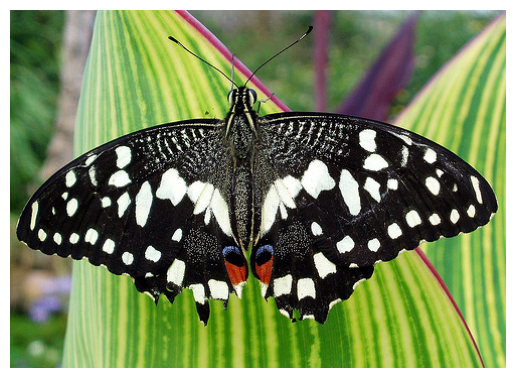

In [41]:
img = cv2.imread('data/images/butterfly.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);
plt.axis('off');

<Figure size 2000x1000 with 0 Axes>

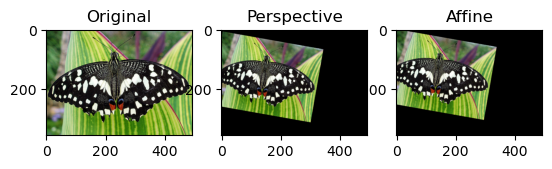

In [90]:
scale_factor = 0.7
rotation_deg = 10
translation = 10

scale_matrix = np.array([[scale_factor, 0, 0, ],
                         [0, scale_factor, 0],
                         [0, 0, 1]])

rotation_rad = np.radians(rotation_deg)
rotation_matrix = np.array([[np.cos(rotation_rad), -np.sin(rotation_rad), 0],
                           [ np.sin(rotation_rad), np.cos(rotation_rad), 0],
                           [0, 0, 1]])

translation_matrix =np.array([[1, 0, translation],
                              [0, 1, translation],
                              [0, 0, 1]])

# Using perspective transformation (3x3)
H1 =np.dot(rotation_matrix, np.dot(scale_matrix, translation_matrix))
output1 = cv2.warpPerspective(img, H1, (img.shape[1], img.shape[0]))

# Using affine transformation (2x3)
H2 = np.dot(rotation_matrix[:-1, :].T, np.dot(scale_matrix[:-1, :], translation_matrix[:-1, :].T)).T
output2 = cv2.warpAffine(img, H2, (img.shape[1], img.shape[0]))

fig, ax = plt.subplots(1, 3)

ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(output1)
ax[1].set_title('Perspective')
ax[2].imshow(output2)
ax[2].set_title('Affine');


## Example 3:

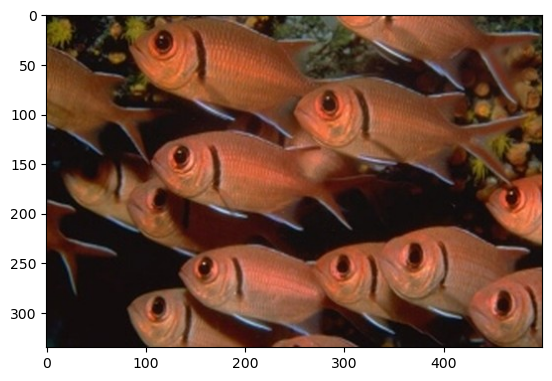

In [95]:
image = cv2.imread('data/images/fishes.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

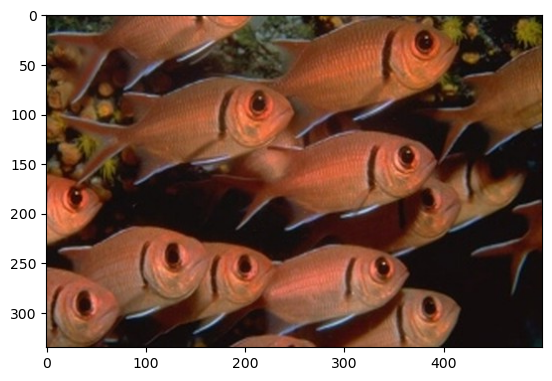

In [103]:
height, width = image.shape[:2]

inputs = np.array([[0, 0],
                  [width-1, 0],
                  [0, height-1]], np.float32)

output = np.array([[width-1, 0],
                   [0,0],
                   [width-1, height-1]], np.float32)

H = cv2.getAffineTransform(inputs, output)
new_image = cv2.warpAffine(image, H, (width, height))
plt.imshow(new_image);

# Image Stitching

## Example 1:

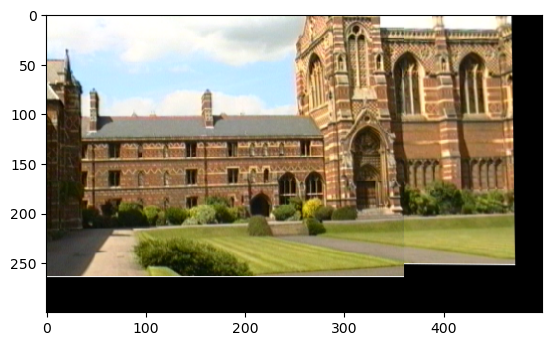

In [54]:
img_reference = cv2.imread('data/images/left-image.png')
img_reference = cv2.cvtColor(img_reference, cv2.COLOR_BGR2RGB)

img_source = cv2.imread('data/images/right-image.png')
img_source = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_reference, None)
kp2, des2 = sift.detectAndCompute(img_source, None)

bf = cv2.BFMatcher()

matches = bf.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# results = cv2.drawMatches(img_reference, kp1, img_source, kp2, good, None, matchColor = (0, 255, 0), flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# plt.imshow(results);

src = np.array([kp2[m.trainIdx].pt for m in good])
dst = np.array([kp1[m.queryIdx].pt for m in good])

H, mask = cv2.findHomography(src, dst, cv2.RANSAC, ransacReprojThreshold=20)

height, width = img_source.shape[:2]
result = cv2.warpPerspective(img_source, H, (width*2, height*2))
height, width = img_reference.shape[:2]

result[0:height, 0:width] = img_reference 
plt.imshow(result[:300,:500])

## Example 2:

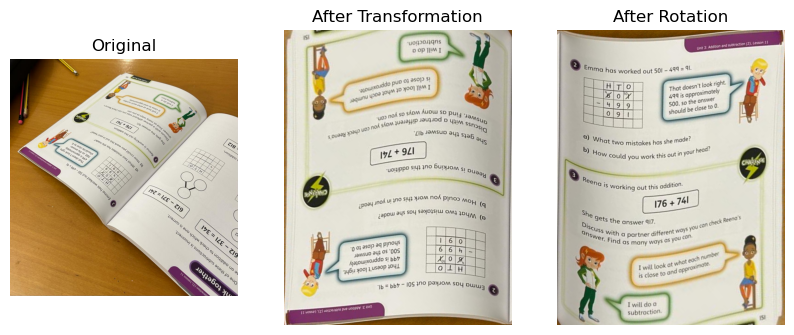

In [68]:
import matplotlib.pyplot as plt
image = cv2.imread(r'C:\Users\ronyf\Computer-Vision-Repository\data\images\book.jpeg')

pts = [[483, 56],
       [857, 244],
       [37, 394],
       [417, 726]]

input_pts = np.array(pts, dtype=np.float32)            

width = (np.linalg.norm(input_pts[0]-input_pts[1]), np.linalg.norm(input_pts[2]-input_pts[3]))      
height = (np.linalg.norm(input_pts[0]-input_pts[2]), np.linalg.norm(input_pts[1]-input_pts[3]))    

width = int(np.max(width))
height = int(np.max(height))

output_pts = np.array([(0, 0),
          (width-1, 0),
          (0, height-1),
          (width-1,height-1)], np.float32)              

H = cv2.getPerspectiveTransform(input_pts, output_pts)             

output_image = cv2.warpPerspective(image, H, (width, height), flags=cv2.INTER_LINEAR)

plt.figure(figsize = (10,8))
plt.subplot(131)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
plt.title('Original')
plt.axis('off');
plt.subplot(132)
plt.title('After Transformation')
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB));
plt.axis('off');

final = cv2.rotate(output_image, cv2.ROTATE_180)
plt.subplot(133)
plt.title('After Rotation')
plt.axis('off');
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB));

## Example 3:

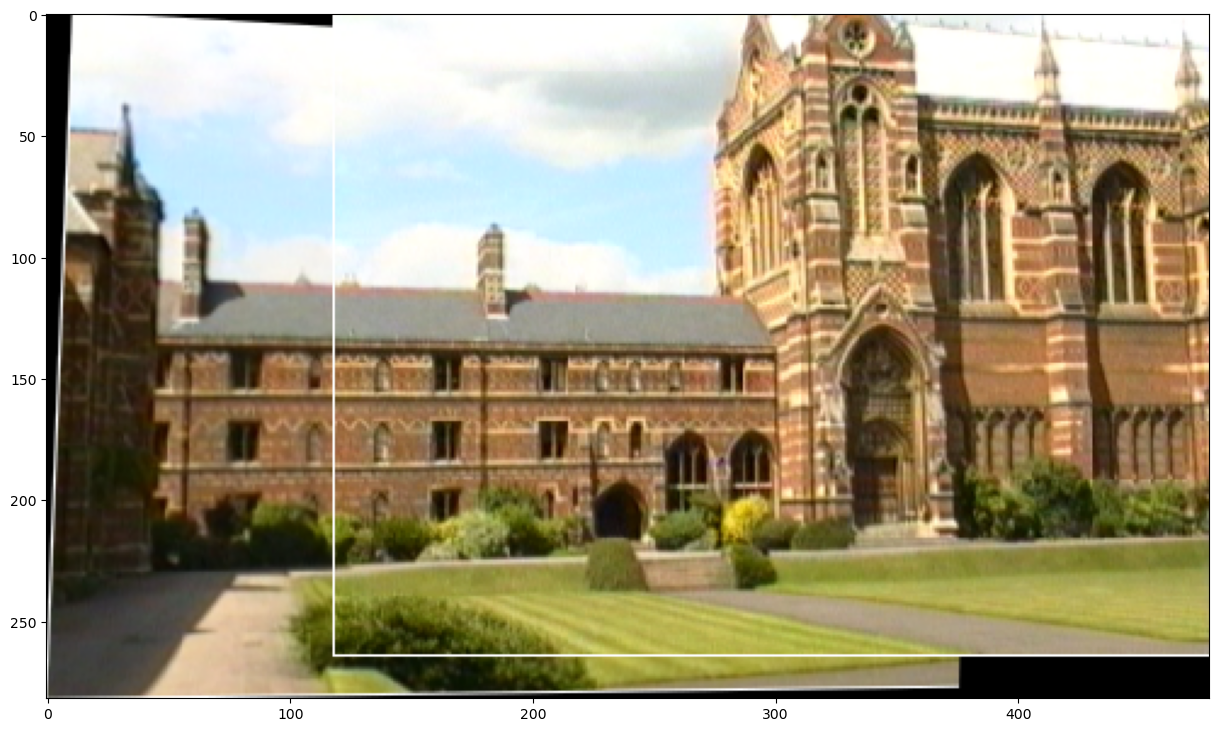

In [71]:
img1 = cv2.imread('data/images/left-image.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread('data/images/right-image.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher()

matches = bf.knnMatch(des1, des2, k =2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

src = np.array([kp1[m.queryIdx].pt for m in good])
dst = np.array([kp2[m.trainIdx].pt for m in good])

H, mask = cv2.findHomography(src, dst, method=cv2.RANSAC, ransacReprojThreshold=5)

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
corners1 = np.array([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)  # each corner is represented as [[x, y]]     
corners2 = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2- 1], [w2 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

transformed_corners = cv2.perspectiveTransform(corners1, H)                     # only corners 1 undergo transformation
transformed_corners = np.concatenate((transformed_corners, corners2), axis=0)   # concatenate arrs along the rows

# Find the minimum and maximum (transformed) coordinates to get the dimensions of the panoramic image
min_x, min_y = np.int32(transformed_corners.min(axis=0).ravel())                # finding the min & max along the first axis -- (x, y) coordinates
                                                                                # ravel() -- flattens the array results
max_x, max_y = np.int32(transformed_corners.max(axis=0).ravel())

# Adjust the homography matrix to account for the shift
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])      # shifting the image by -minx_x & min_y (so that it starts from (0, 0))
adjusted_homography_matrix = np.dot(translation_matrix, H)                      # apply translation to the original homography matrix H

# Apply the adjusted homography to warp the image
stitched_image = cv2.warpPerspective(img1, adjusted_homography_matrix, (max_x - min_x + 1, max_y - min_y + 1))
stitched_image[-min_y:img2.shape[0] - min_y, -min_x:img2.shape[1] - min_x,:] = img2    # overlays img2 onto the stitched image, ensuring that it aligns properly with img1
                                                                                             # the negative indexing is used to ensure correct placement of img2 in the stitched image.

# Display or save the stitched image
plt.figure(figsize=(15,15))
plt.imshow(stitched_image)